In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    recall_score,
    f1_score,
    make_scorer
)

from sklearn.model_selection import cross_validate


In [46]:
ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2025-11-01')

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# =========================
# Feature Engineering
# =========================

data['Returns'] = data['Close'].pct_change()
data['EMA30'] = data['Close'].ewm(span=30, adjust=False).mean()
data['ROC_10'] = data['Close'].pct_change(periods=10)
data['Daily_Range'] = (data['High'] - data['Low']) / data['Close']
data['Volatilidad_10d'] = data['Returns'].rolling(window=10).std()
data['Vol_Relativo'] = data['Volume'] / data['Volume'].rolling(window=30).mean()

data['Money_Flow'] = data['Returns'] * data['Volume']
data['MFI_5'] = data['Money_Flow'].rolling(window=5).mean()

# Volume Force
data['Vol_Force'] = data['Returns'] * (data['Volume'] / data['Volume'].rolling(window=20).mean())

# Filtro técnico (no entra al modelo)
data['Above_EMA30'] = (data['Close'] > data['EMA30']).astype(int)

# Target: subida > 0.3% mañana
data['Target'] = (data['Close'].shift(-1) > data['Close'] * 1.005).astype(int)

data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [47]:
features = [
    'Returns',
    'ROC_10',
    'Daily_Range',
    'Vol_Relativo',
    'MFI_5',
    'Vol_Force'
]

X = data[features]
y = data['Target']

split = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [48]:
best_model = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\n--- RESULTADOS TEST SET ---")
print(classification_report(y_test, y_pred))



--- RESULTADOS TEST SET ---
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       210
           1       0.41      0.32      0.36       128

    accuracy                           0.57       338
   macro avg       0.53      0.52      0.52       338
weighted avg       0.55      0.57      0.56       338



In [49]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=3,
    scoring=scoring_metrics,
    return_train_score=False
)

print("\n--- CROSS VALIDATION (TRAIN) ---")
print("Accuracy:", np.mean(cv_results['test_accuracy']))
print("Recall:  ", np.mean(cv_results['test_recall']))
print("F1:      ", np.mean(cv_results['test_f1']))



--- CROSS VALIDATION (TRAIN) ---
Accuracy: 0.5318075059538474
Recall:   0.3314917127071823
F1:       0.36039983059670305



--- IMPORTANCIA DE FEATURES ---
Returns         0.171599
MFI_5           0.169865
Vol_Relativo    0.168205
Daily_Range     0.166962
Vol_Force       0.162905
ROC_10          0.160465
dtype: float32


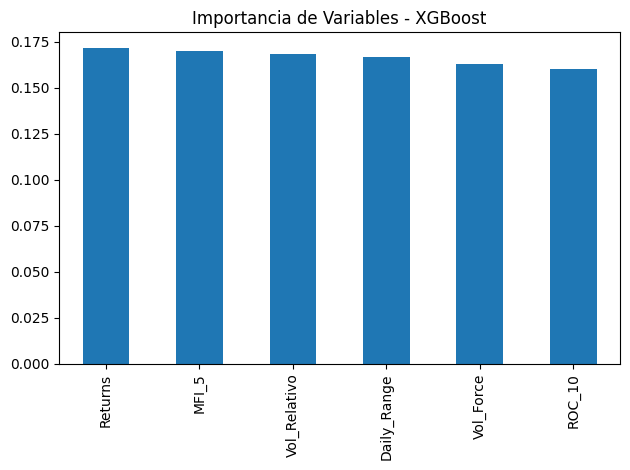

In [50]:
importances = pd.Series(
    best_model.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE FEATURES ---")
print(importances)

importances.plot(kind='bar', title='Importancia de Variables - XGBoost')
plt.tight_layout()
plt.show()


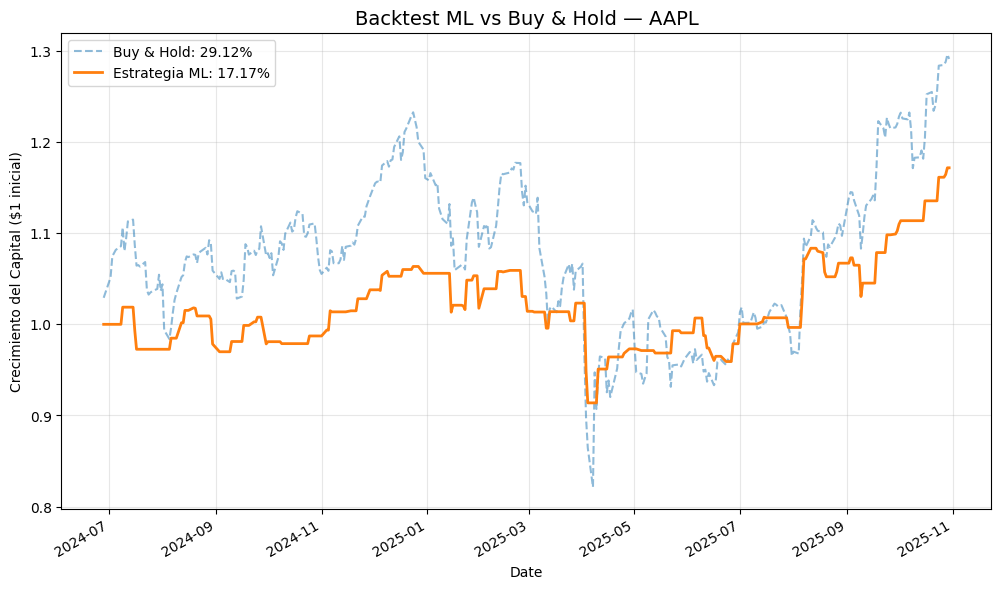


--- RESULTADOS FINANCIEROS ---
Rendimiento Total Estrategia: 17.17%
Rendimiento Buy & Hold:       29.12%
Alpha vs Mercado:             -11.95%
Sharpe (full series):         0.86
Sharpe (solo trades):         1.60
Número de operaciones:        97
Win Rate:                     58.76%
Máximo Drawdown:              -14.07%


In [51]:
# ==========================================
# BACKTESTING Y MÉTRICAS FINANCIERAS
# ==========================================

results = X_test.copy()

# Retorno de mañana (close-to-close)
results['Next_Day_Return'] = data['Close'].pct_change().shift(-1).loc[X_test.index]

# Retorno estrategia: solo cuando hay señal filtrada
results['Strategy_Return'] = y_pred * results['Next_Day_Return']

results.dropna(inplace=True)

# Curvas de capital
strategy_series = (1 + results['Strategy_Return']).cumprod()
market_series = (1 + results['Next_Day_Return']).cumprod()

# Rendimientos totales
rendimiento_estrategia = (strategy_series.iloc[-1] - 1) * 100
rendimiento_buy_hold = (market_series.iloc[-1] - 1) * 100

# Sharpe Ratio (incluye días sin posición)
sharpe_full = (results['Strategy_Return'].mean() / results['Strategy_Return'].std()) * np.sqrt(252)

# Sharpe solo en días con trade
trade_returns = results.loc[results['Strategy_Return'] != 0, 'Strategy_Return']
sharpe_trades = (trade_returns.mean() / trade_returns.std()) * np.sqrt(252)

# Win Rate y número de operaciones
num_trades = len(trade_returns)
win_rate = (trade_returns > 0).mean() * 100

# Máximo Drawdown
rolling_max = strategy_series.cummax()
drawdown = (strategy_series - rolling_max) / rolling_max
max_dd = drawdown.min() * 100

# =========================
# GRÁFICO
# =========================

plt.figure(figsize=(12,7))
market_series.plot(label=f'Buy & Hold: {rendimiento_buy_hold:.2f}%', linestyle='--', alpha=0.5)
strategy_series.plot(label=f'Estrategia ML: {rendimiento_estrategia:.2f}%', linewidth=2)

plt.title(f'Backtest ML vs Buy & Hold — {ticker}', fontsize=14)
plt.ylabel('Crecimiento del Capital ($1 inicial)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =========================
# RESULTADOS CONSOLA
# =========================

print("\n--- RESULTADOS FINANCIEROS ---")
print(f"Rendimiento Total Estrategia: {rendimiento_estrategia:.2f}%")
print(f"Rendimiento Buy & Hold:       {rendimiento_buy_hold:.2f}%")
print(f"Alpha vs Mercado:             {rendimiento_estrategia - rendimiento_buy_hold:.2f}%")
print(f"Sharpe (full series):         {sharpe_full:.2f}")
print(f"Sharpe (solo trades):         {sharpe_trades:.2f}")
print(f"Número de operaciones:        {num_trades}")
print(f"Win Rate:                     {win_rate:.2f}%")
print(f"Máximo Drawdown:              {max_dd:.2f}%")
